In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import sys
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from spec2D import Spec2D
from binnedFit_utilities import velocity_to_lambda

sys.path.append(dir_KLens)
from KLtool import plot_specs
from tfCube2 import TFCube

In [2]:
import astropy.units as u

sys.path.append(dir_BinnedFit+'/tests')
from get_pars import get_pars0
from gen_mocks import gen_mock_tfCube

# ========= generate example mock dataInfo ========= # 

pars, line_species = get_pars0()
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['sini'] = 0.4

dataInfo = gen_mock_tfCube(pars, line_species, slits='both', noise_mode=0)


keys = ['g1', 'g2', 'sini', 'slitWidth', 'theta_int', 'slitAngles']
for key in keys:
    if key == 'slitAngles':
        slitAng_deg = dataInfo['par_fid'][key]*180./np.pi
        print(key, ':', slitAng_deg, '(deg)')
    else:
        print(key, ':',dataInfo['par_fid'][key])

g1 : 0.0
g2 : 0.0
sini : 0.4
slitWidth : 0.12
theta_int : 0.0
slitAngles : [ 0. 90.] (deg)


# 0. create a Spec2D object

In [3]:
spec_array = dataInfo['spec'][0].array
spec_var = dataInfo['spec_variance'][0]

print(f'original spec_array dim. = {spec_array.shape}')

spec2D = Spec2D(array=spec_array, array_var=spec_var, 
                spaceGrid=dataInfo['spaceGrid'], lambdaGrid=dataInfo['lambdaGrid'], 
                line_species=line_species, z=dataInfo['par_fid']['redshift'], auto_cut=False)

print(f'after auto_cut spec array dim. = {spec2D.array.shape}')

original spec_array dim. = (128, 122)
after auto_cut spec array dim. = (128, 122)


# 1. display

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc182938b50>)

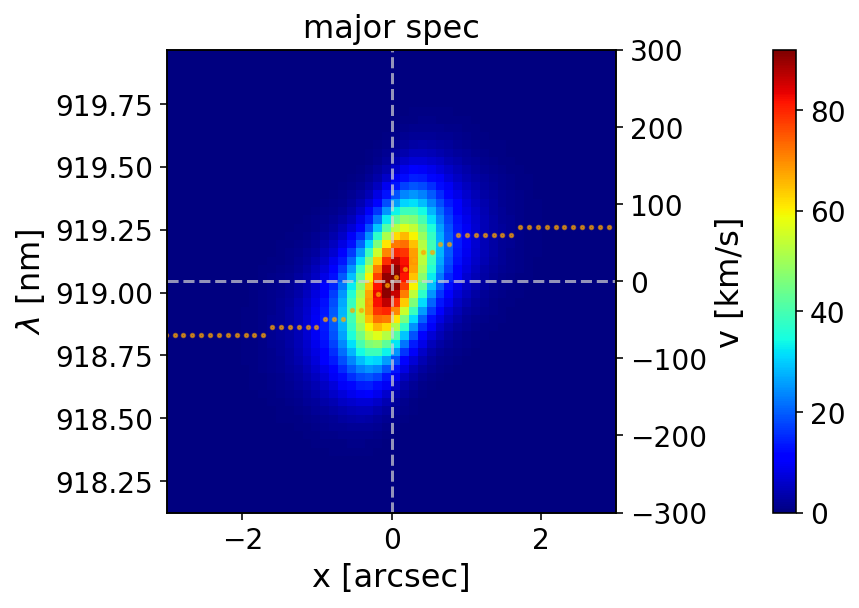

In [4]:
spec2D.display(xlim=[-3.,3.], vlim=[-300.,300.], mark_cen=True, mark_peak=True, title='major spec')

### - mark_fit=True (display summary statistics)

time cost in gaussFit_spec2D: 0.08705306053161621 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc182a1f350>)

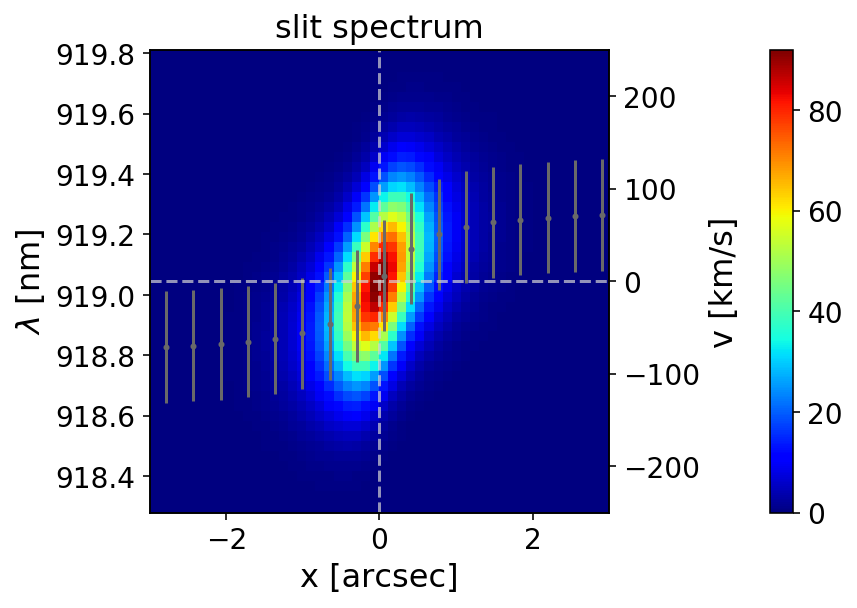

In [5]:
lambda0, z = dataInfo['par_fid']['lambda0'], dataInfo['par_fid']['redshift']
#ylim = velocity_to_lambda(v=[-250.,250.], lambda0=lambda0, z=z)

spec2D.display(xlim=[-3.0,3.0], vlim=[-250.,250.], mark_cen=True, mark_fit=True)

### use the keyward, model=model_arr to overplot model contours with data

In [6]:
from gaussFit import GaussFit
GF = GaussFit(spec2D=spec2D)
model = GF.model

time cost in gaussFit_spec2D: 0.07492399215698242 (secs)


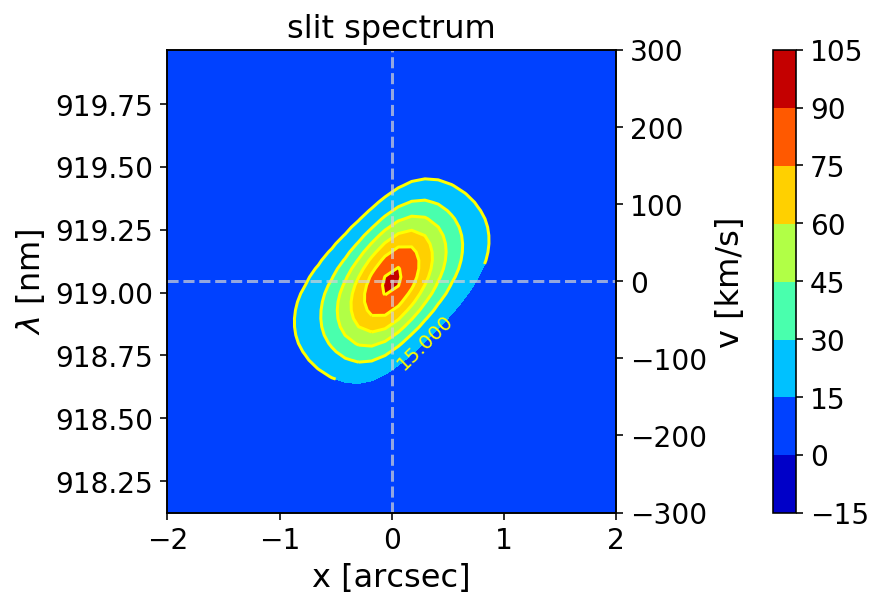

In [7]:
fig, ax = spec2D.display(xlim=[-2.0,2.0], vlim=[-300.,300.], mark_cen=True, model=model)
# model contours are overplotted with the mock data (colored contours).

### - overplot other lines on top of ax

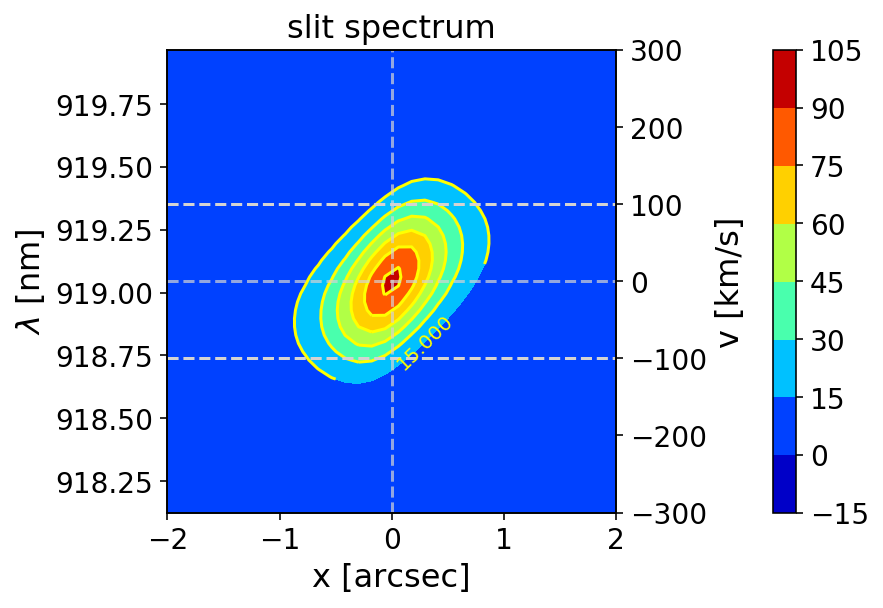

In [8]:
from IPython.display import display as ipython_display

lambda_mark = velocity_to_lambda(v=100., lambda0=lambda0, z=z)
ax.axhline(y=lambda_mark, color='lightgray', ls='--')

lambda_mark = velocity_to_lambda(v=-100., lambda0=lambda0, z=z)
ax.axhline(y=lambda_mark, color='lightgray', ls='--')

ipython_display(fig)

# 2. SNR for position bins

Text(0, 0.5, 'SNR')

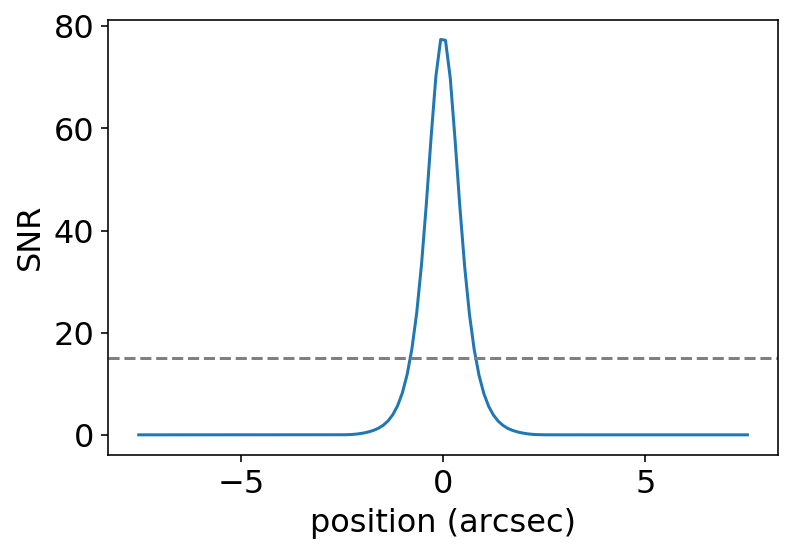

In [9]:
plt.plot(spec2D.spaceGrid, spec2D.SNR_pos)
plt.axhline(15, color='gray', ls='--')
plt.xlabel('position (arcsec)')
plt.ylabel('SNR')


# 3. cutout

### - cutout with thresholdSNR

before cutout : array.shape = (128, 122)
after cutout : array.shape = (14, 122)


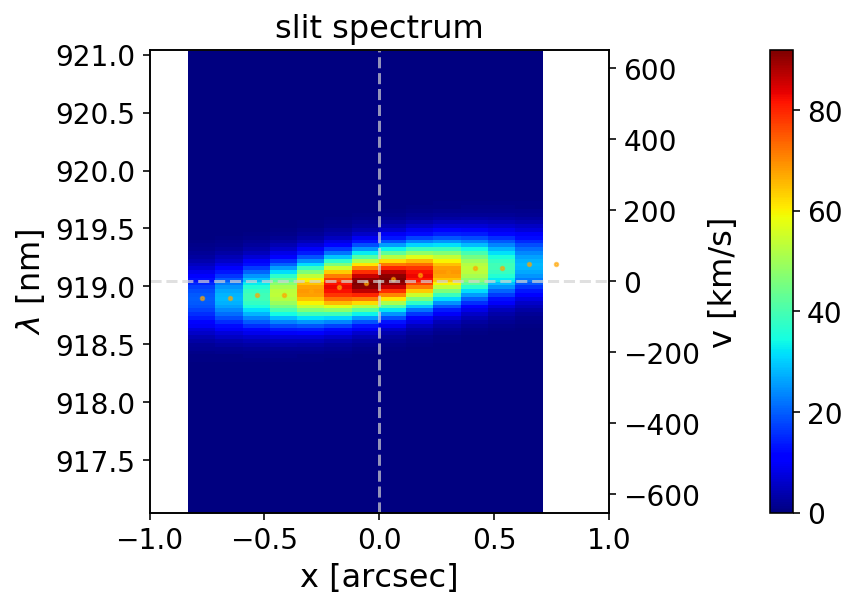

In [10]:
print(f'before cutout : array.shape = {spec2D.array.shape}')

spec2Dcut = spec2D.cutout(thresholdSNR=16)

print(f'after cutout : array.shape = {spec2Dcut.array.shape}')

fig, ax=spec2Dcut.display(mark_peak=True, xlim=[-1, 1], mark_cen=True)

### - cutout with xlim

before cutout : array.shape = (128, 122)
after cutout : array.shape = (34, 122)


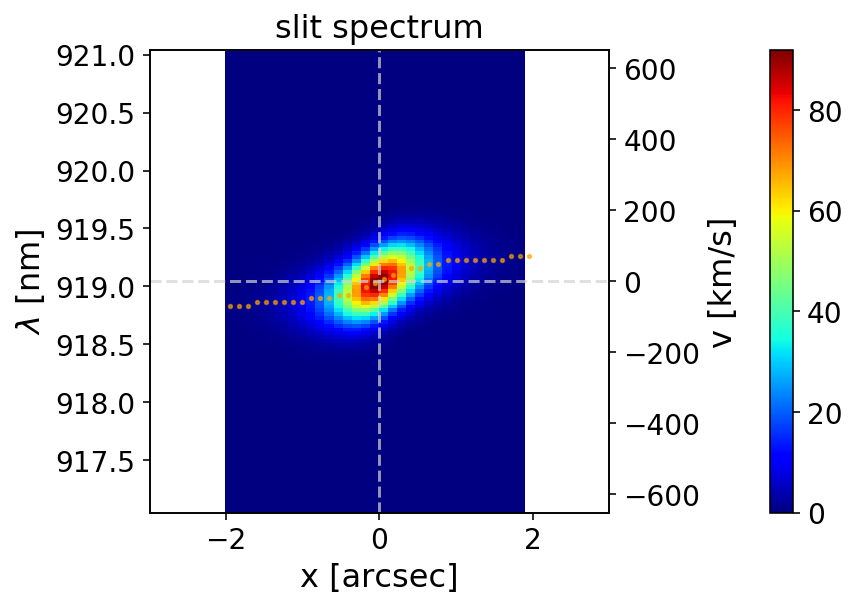

In [11]:
print(f'before cutout : array.shape = {spec2D.array.shape}')

spec2Dcut = spec2D.cutout(xlim=[-2,2])

print(f'after cutout : array.shape = {spec2Dcut.array.shape}')

fig, ax=spec2Dcut.display(mark_peak=True, xlim=[-3, 3], mark_cen=True)

# ------ END ------